# Task 1A (20 points)

# Image and patch generation functions

57 berries simulated


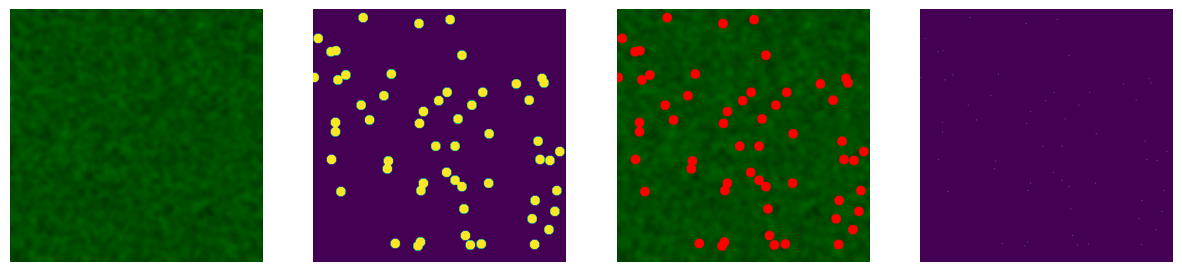

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 75 berries randomly placed
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.disk((berry_cx[idx], berry_cy[idx]),
                         radius=10,
                         shape=berries.shape)
    berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # red

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [ ]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img,
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

# Train a regression model to predict density

In [ ]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.05529055
(12288,) 0.0 0.092769705
(12288,) 2.0 0.10417218


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 64)       

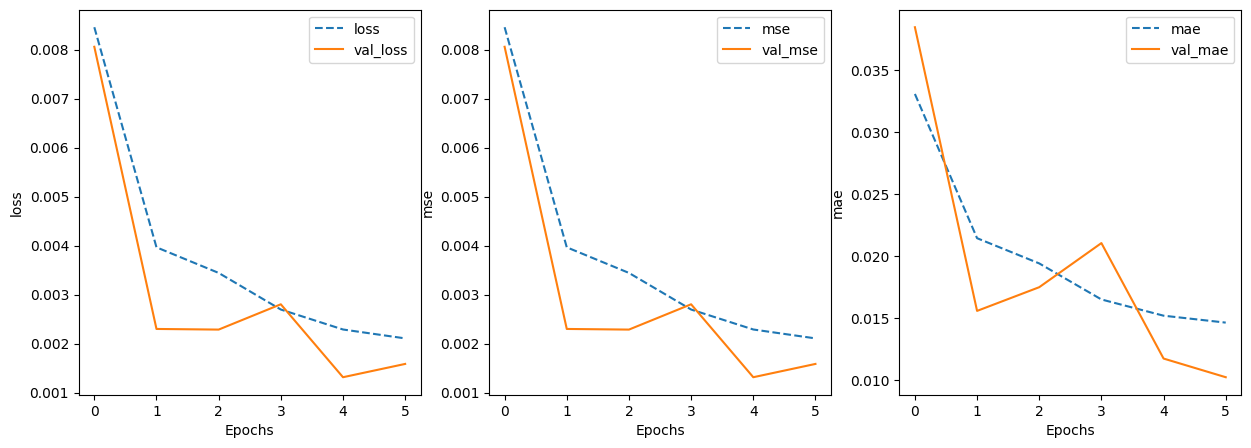

In [ ]:
# Train
NUM_TRAIN = 300 # 10000 more realistic
NUM_EVAL = 20 # 1000 more realistic
NUM_EPOCHS = 6

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course
  # the patch is flattened, so we start by reshaping to an image
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer,
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

35 berries simulated
8/8 [==============================] - 0s 35ms/step
32 berries simulated
8/8 [==============================] - 0s 55ms/step
25 berries simulated
8/8 [==============================] - 0s 48ms/step
35 berries simulated
8/8 [==============================] - 0s 35ms/step
57 berries simulated
8/8 [==============================] - 0s 34ms/step
26 berries simulated
8/8 [==============================] - 0s 33ms/step
58 berries simulated
8/8 [==============================] - 0s 35ms/step
36 berries simulated
8/8 [==============================] - 0s 35ms/step
49 berries simulated
8/8 [==============================] - 0s 35ms/step
42 berries simulated
8/8 [==============================] - 0s 33ms/step
65 berries simulated
8/8 [==============================] - 0s 35ms/step
28 berries simulated
8/8 [==============================] - 0s 33ms/step
38 berries simulated
8/8 [==============================] - 0s 35ms/step
38 berries simulated
8/8 [=========================

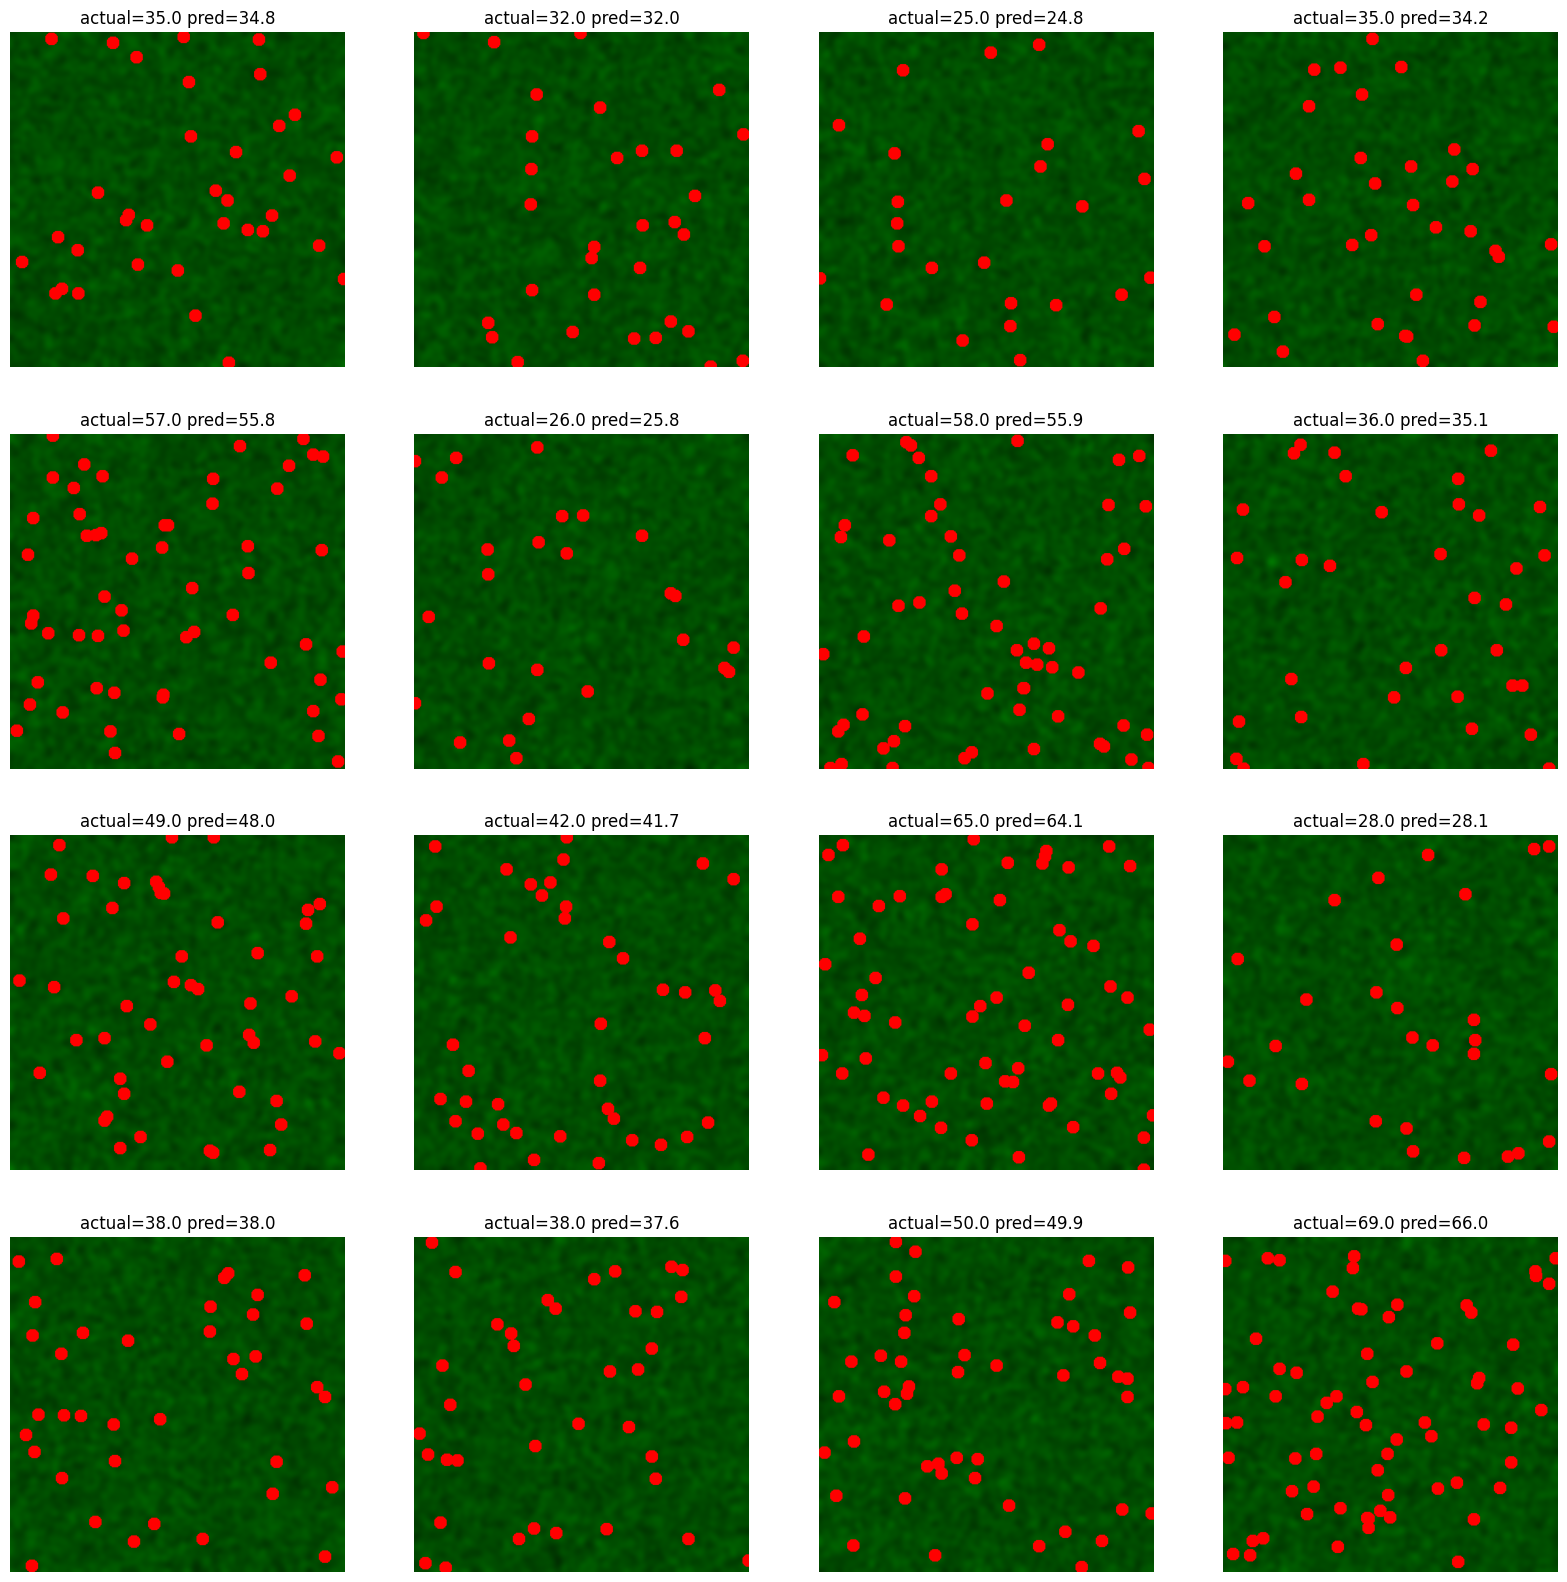

In [ ]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

# Actual image

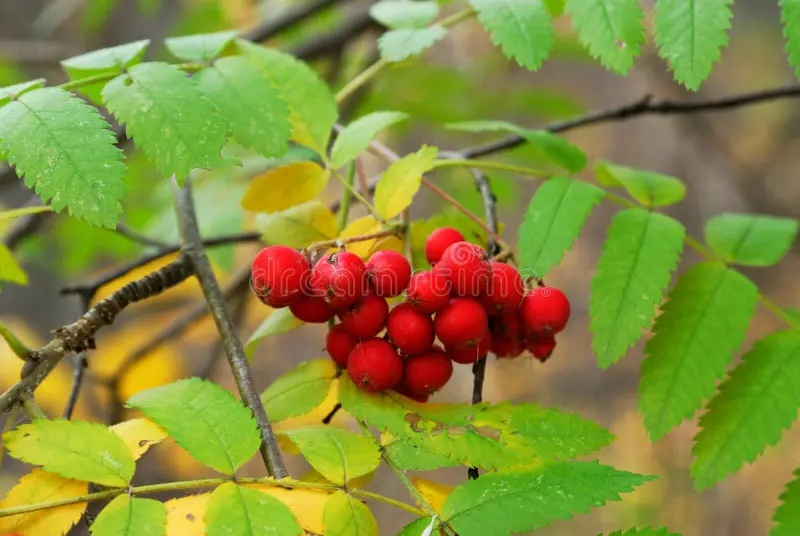

In [ ]:
!file berries.jpeg

berries.jpeg: JPEG image data, JFIF standard 1.01, aspect ratio, density 72x72, segment length 16, Exif Standard: [TIFF image data, big-endian, direntries=2, orientation=upper-left], baseline, precision 8, 800x536, components 3


In [ ]:
contents = tf.io.read_file('./berries.jpeg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 34ms/step
61.698425


# Task 1B (30 points)

# Image and patch generation functions

53 berries simulated with 41% bad berries


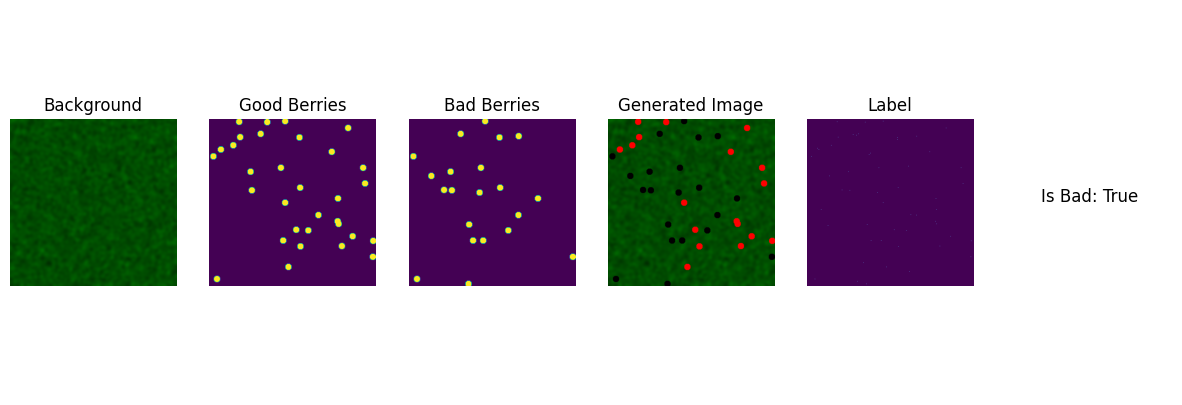

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
    # the image has a random greenish background that is smoothed
    backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
    backgr[np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1] = 1
    backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

    # between 25 and 75 berries randomly placed
    num_berries = np.random.randint(25, 75)
    berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
    berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)

    # generate a random percentage of bad berries between 0 and 100
    bad_percentage = np.random.randint(0, 101)
    num_bad_berries = int(num_berries * bad_percentage / 100)

    # create the bad berries by randomly selecting some existing berries
    bad_berry_indices = np.random.choice(num_berries, size=num_bad_berries, replace=False)
    label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
    label[berry_cx, berry_cy] = 1

    # draw the good berries which are 10 px in radius
    good_berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
    for idx in range(num_berries - num_bad_berries):
        rr, cc = draw.disk((berry_cx[idx], berry_cy[idx]),
                           radius=10,
                           shape=good_berries.shape)
        good_berries[rr, cc] = 1

    # draw the bad berries as black
    bad_berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
    for idx in bad_berry_indices:
        rr, cc = draw.disk((berry_cx[idx], berry_cy[idx]),
                           radius=10,
                           shape=bad_berries.shape)
        bad_berries[rr, cc] = 1

    # add berries to the background
    img = np.copy(backgr)
    img[good_berries > 0] = [1, 0, 0]  # red
    img[bad_berries > 0] = [0, 0, 0]  # black

    # Check if the image is bad (black berries exceed 50% of total berries)
    is_bad = np.sum(bad_berries) > (0.5 * np.sum(good_berries))

    if with_intermediates:
        print("{} berries simulated with {}% bad berries".format(num_berries, bad_percentage))
        return backgr, good_berries, bad_berries, img, label, is_bad
    else:
        return img, label, is_bad

images = generate_image(True)
backgr, good_berries, bad_berries, img, label, is_bad = images

f, ax = plt.subplots(1, 6, figsize=(15, 5))
ax[0].imshow(backgr)
ax[0].set_title("Background")
ax[0].axis('off')

ax[1].imshow(good_berries)
ax[1].set_title("Good Berries")
ax[1].axis('off')

ax[2].imshow(bad_berries)
ax[2].set_title("Bad Berries")
ax[2].axis('off')

ax[3].imshow(img)
ax[3].set_title("Generated Image")
ax[3].axis('off')

ax[4].imshow(label)
ax[4].set_title("Label")
ax[4].axis('off')

ax[5].text(0.5, 0.5, "Is Bad: {}".format(is_bad), fontsize=12, ha='center')
ax[5].axis('off')

plt.show()


In [ ]:
# Given an image, get the patches
def get_patches(img, label, verbose=False):
    img = tf.expand_dims(img, axis=0)
    label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
    if verbose:
        print(img.shape, label.shape)
    num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
    patches = tf.image.extract_patches(img,
                                       sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                       strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='SAME',
                                       name='get_patches')
    patches = tf.reshape(patches, [num_patches, -1])
    labels = tf.image.extract_patches(label,
                                      sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                      strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                      rates=[1, 1, 1, 1],
                                      padding='VALID',
                                      name='get_labels')
    labels = tf.reshape(labels, [num_patches, -1])
    # the "density" is the number of points in the label patch
    patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
    if verbose:
        print(patches.shape, labels.shape, patch_labels.shape)
    return patches, patch_labels

# Train a regression model to predict density

In [ ]:
# Getting input data
def create_dataset(num_full_images):
    def generate_patches():
        for i in range(num_full_images):
            img, label, is_bad = generate_image()
            patches, patch_labels = get_patches(img, label)
            # print(len(patches) * num_full_images)
            for patch, patch_label in zip(patches, patch_labels):
                yield patch, patch_label

    return tf.data.Dataset.from_generator(
        generate_patches,
        (tf.float32, tf.float32),  # patch, patch_label
        (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
         tf.TensorShape([]))
    )

trainds = create_dataset(1)  # will create 256 patches per image
for img, label in trainds.take(3):
    avg = tf.math.reduce_mean(img)  # avg pixel in image
    print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.07375427
(12288,) 1.0 0.08726141
(12288,) 1.0 0.06893397


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 64, 64, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 12, 12, 64)       

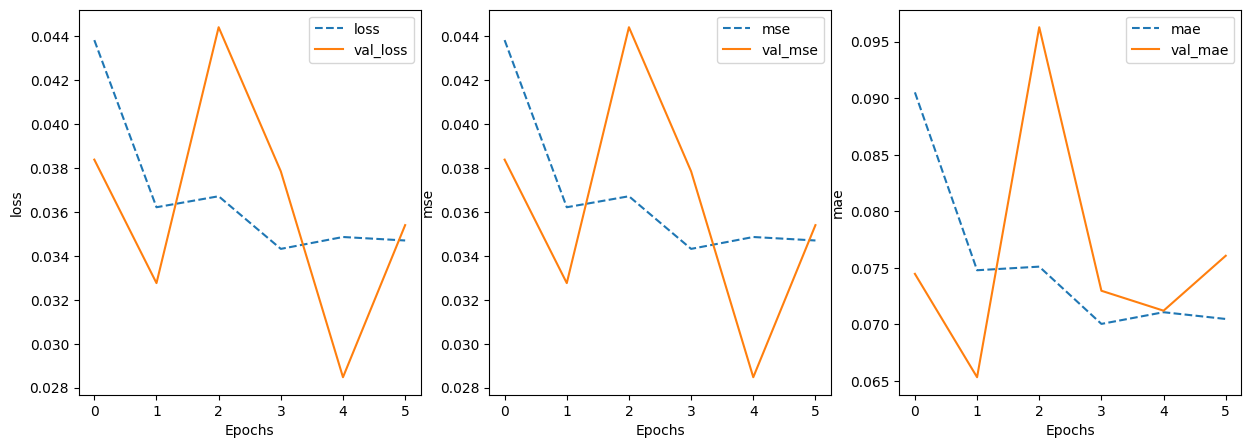

In [ ]:
# Train
NUM_TRAIN = 300  # 10000 more realistic
NUM_EVAL = 20  # 1000 more realistic
NUM_EPOCHS = 6

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size=32,
                       lrate=0.001,  # default in Adam constructor
                       l1=0,
                       l2=0,
                       num_filters=32):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
    eval_dataset = create_dataset(NUM_EVAL).batch(64)

    # a simple convnet. you can make it more complex, of course
    # the patch is flattened, so we start by reshaping to an image
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
        tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_filters*2,
                              kernel_regularizer=regularizer,
                              activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'mse', 'mae'], history)
    return model

model = train_and_evaluate()

66 berries simulated with 81% bad berries
8/8 [==============================] - 0s 35ms/step
32 berries simulated with 74% bad berries
8/8 [==============================] - 0s 36ms/step
38 berries simulated with 63% bad berries
8/8 [==============================] - 0s 34ms/step
40 berries simulated with 47% bad berries
8/8 [==============================] - 0s 35ms/step
71 berries simulated with 79% bad berries
8/8 [==============================] - 0s 35ms/step
37 berries simulated with 72% bad berries
8/8 [==============================] - 0s 36ms/step
53 berries simulated with 53% bad berries
8/8 [==============================] - 0s 36ms/step
70 berries simulated with 60% bad berries
8/8 [==============================] - 0s 35ms/step
40 berries simulated with 93% bad berries
8/8 [==============================] - 0s 35ms/step
37 berries simulated with 54% bad berries
8/8 [==============================] - 0s 35ms/step
36 berries simulated with 81% bad berries
8/8 [=============

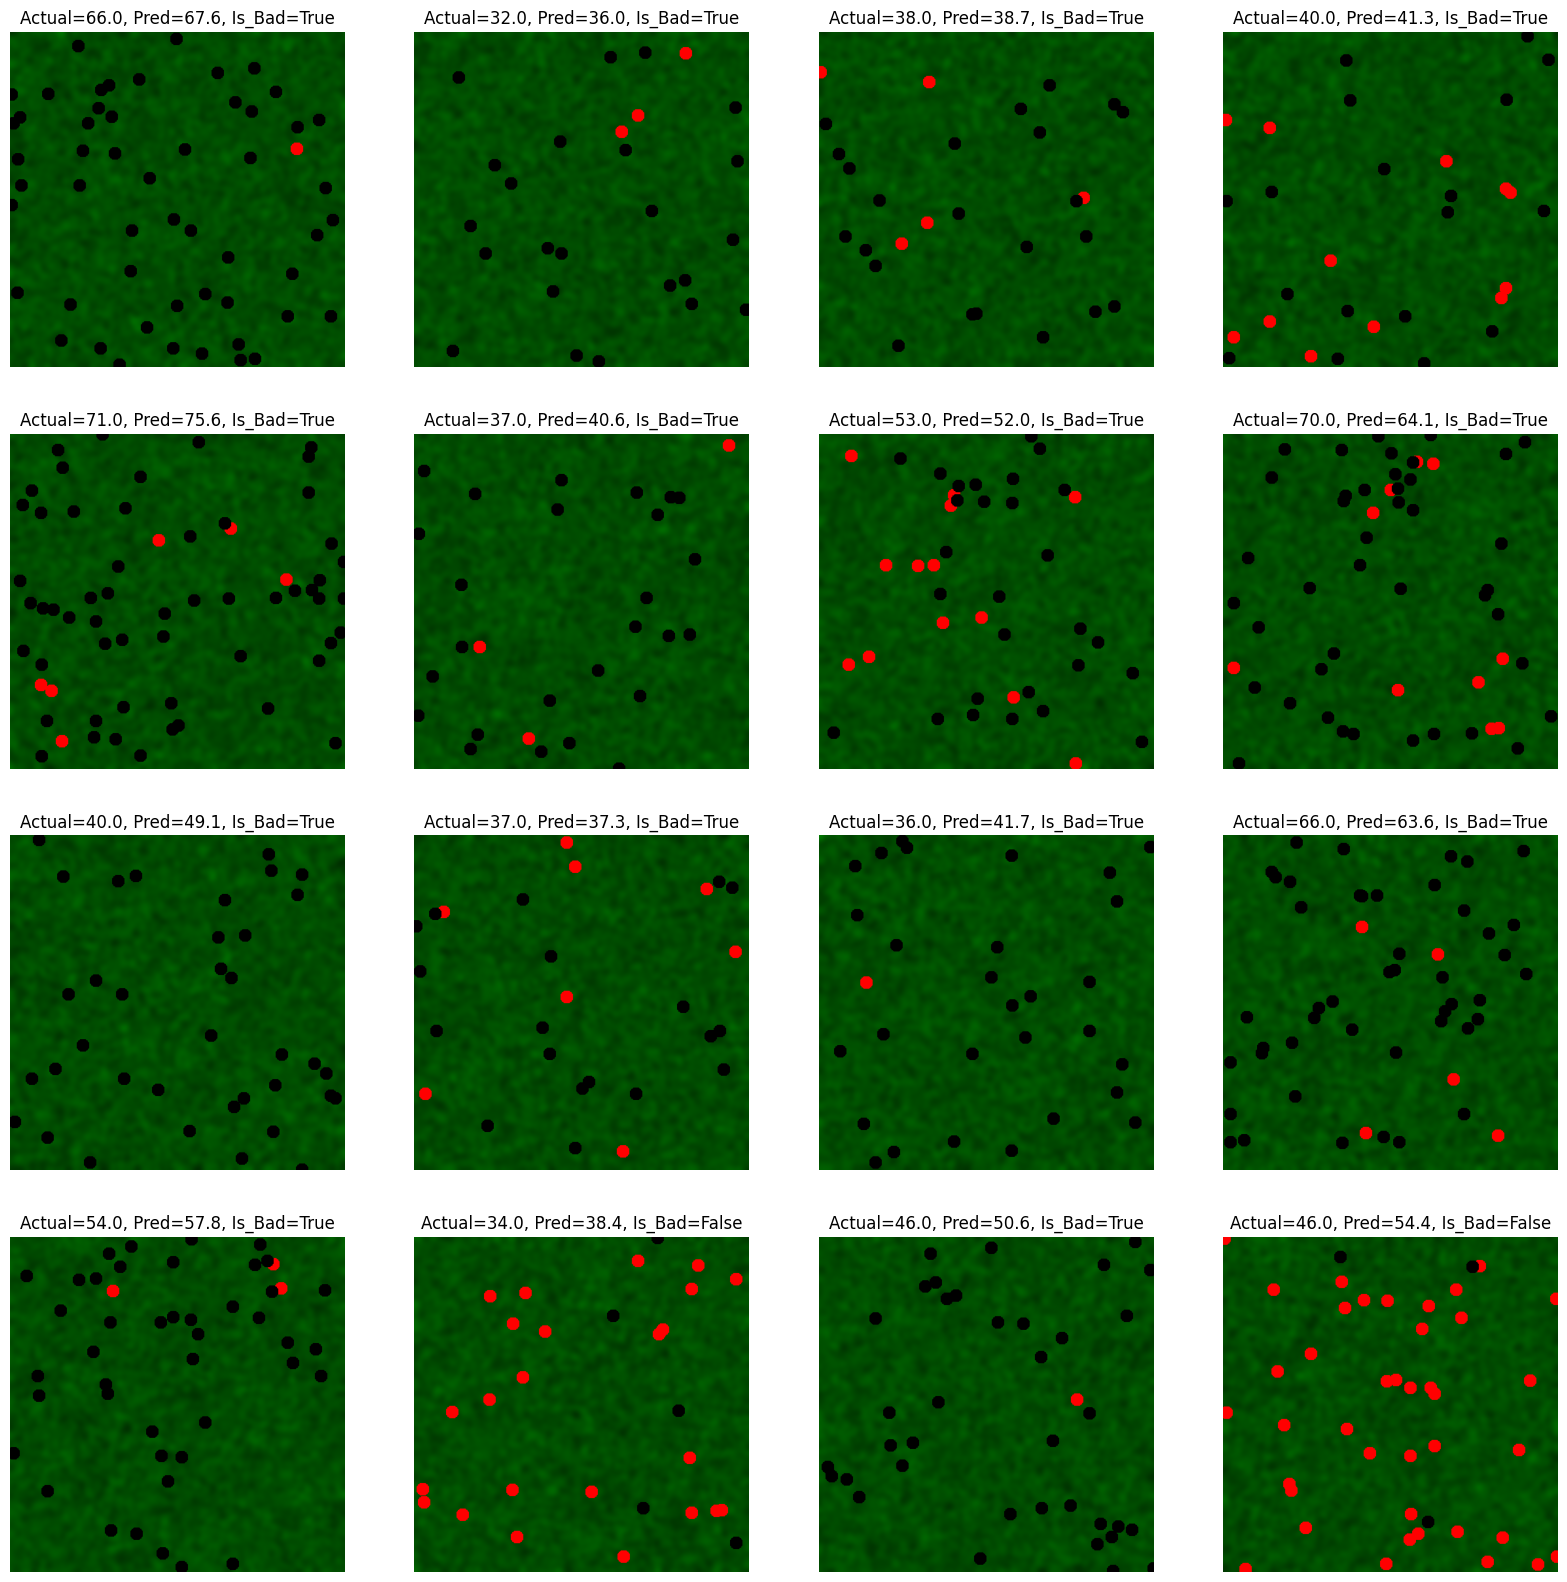

In [ ]:
## Prediction
def count_berries(model, img):
    num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
    img = tf.expand_dims(img, axis=0)
    patches = tf.image.extract_patches(img,
                                       sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                       strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='SAME',
                                       name='get_patches')
    patches = tf.reshape(patches, [num_patches, -1])
    densities = model.predict(patches)
    return tf.reduce_sum(densities)

# Use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
    backgr, good_berries, bad_berries, img, label, is_bad = generate_image(True)
    ax[idx//4, idx%4].imshow(img)
    ax[idx//4, idx%4].set_title("Actual={:.1f}, Pred={:.1f}, Is_Bad={}".format(
        tf.reduce_sum(label).numpy(),
        count_berries(model, img).numpy(),
        is_bad
    ))
    ax[idx//4, idx%4].axis('off')

# Actual image

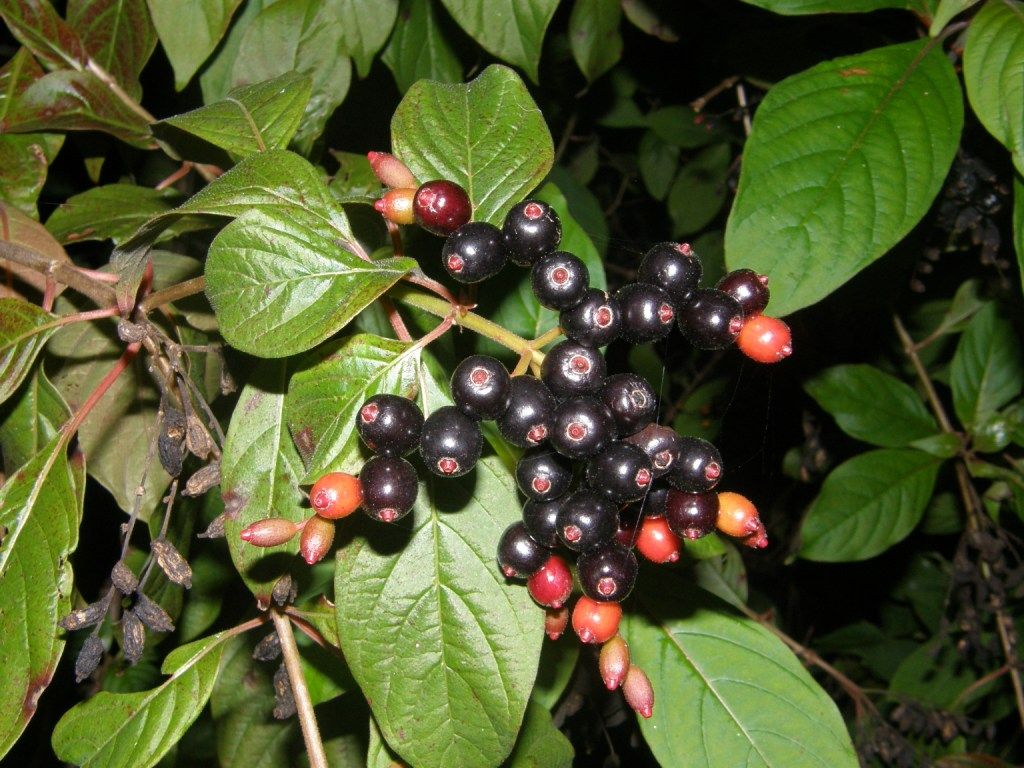

In [ ]:
!file berries_1.jpeg

berries_1.jpeg: JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, Exif Standard: [TIFF image data, big-endian, direntries=12, description=OLYMPUS DIGITAL CAMERA         , manufacturer=OLYMPUS IMAGING CORP.  , model=SP550UZ                , orientation=upper-left, software=Version 1.0                    , datetime=2009:11:02 17:56:34], baseline, precision 8, 1024x768, components 3


In [ ]:
contents = tf.io.read_file('./berries_1.jpeg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

8/8 [==============================] - 0s 34ms/step
927.89484


In this approach, generate images with a random percentage of bad berries ranging from 0% to 100%.
If the percentage of black berries is greater than 50%, mark the image as bad.

Implement the CNN-based model for separating bad crops with black berries exceeding 50% of the total berries.The CNN learns to recognize patterns and features related to both the overall berry counting and identifying whether a patch contains good or bad berries. This allows the model to have a better understanding of the underlying patterns in the data and make more accurate predictions.



# Task 2 (50 points)

In [ ]:
# Load and preprocess the dataset
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

# Preprocess the images
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Build and train the model without transfer learning
tf.random.set_seed(42)
model_no_transfer = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_no_transfer.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

history_no_transfer = model_no_transfer.fit(train_set, epochs=10,
                                            validation_data=valid_set)


Epoch 1/10
86/86 [==============================] - 23s 98ms/step - loss: 7.2668 - accuracy: 0.4237 - val_loss: 1.2575 - val_accuracy: 0.5009
Epoch 2/10
86/86 [==============================] - 8s 88ms/step - loss: 0.8105 - accuracy: 0.7166 - val_loss: 1.1244 - val_accuracy: 0.5699
Epoch 3/10
86/86 [==============================] - 7s 67ms/step - loss: 0.5438 - accuracy: 0.8201 - val_loss: 1.1389 - val_accuracy: 0.5699
Epoch 4/10
86/86 [==============================] - 7s 67ms/step - loss: 0.3108 - accuracy: 0.9244 - val_loss: 1.1799 - val_accuracy: 0.5554
Epoch 5/10
86/86 [==============================] - 7s 76ms/step - loss: 0.1941 - accuracy: 0.9604 - val_loss: 1.3357 - val_accuracy: 0.5426
Epoch 6/10
86/86 [==============================] - 7s 76ms/step - loss: 0.1332 - accuracy: 0.9749 - val_loss: 1.5295 - val_accuracy: 0.5136
Epoch 7/10
86/86 [==============================] - 8s 71ms/step - loss: 0.0771 - accuracy: 0.9927 - val_loss: 1.4526 - val_accuracy: 0.5463
Epoch 8/10
8

In [ ]:
# Build and train the model with transfer learning
tf.random.set_seed(42)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model_transfer = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_transfer.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

history_transfer = model_transfer.fit(train_set, epochs=10,
                                      validation_data=valid_set)

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10
86/86 [==============================] - 24s 208ms/step - loss: 0.4880 - accuracy: 0.8194 - val_loss: 0.4276 - val_accuracy: 0.8312
Epoch 2/10
86/86 [==============================] - 15s 167ms/step - loss: 0.2388 - accuracy: 0.9211 - val_loss: 0.3671 - val_accuracy: 0.8675
Epoch 3/10
86/86 [==============================] - 15s 170ms/step - loss: 0.1500 - accuracy: 0.9535 - val_loss: 0.3825 - val_accuracy: 0.8639
Epoch 4/10
86/86 [==============================] - 15s 170ms/step - loss: 0.1106 - accuracy: 0.9680 - val_loss: 0.3531 - val_accuracy: 0.8875
Epoch 5/10
86/86 [==============================] - 16s 167ms/step - loss: 0.0723 - accuracy: 0.9833 - val_loss: 0.3752 - val_accuracy: 0.8838
Epoch 6/10
86/86 [==============================] - 15s 167ms/step - loss: 0.0564 - accuracy: 0.9866 - val_loss: 0.4579 - val_accuracy: 0.8748
Epoch 7/10
86/86 [==============================] - 15s 167ms/step - loss: 0.

In [ ]:
# Print and compare the accuracy
print("No Transfer Learning - Training Accuracy: ", history_no_transfer.history['accuracy'][-1])
print("No Transfer Learning - Validation Accuracy: ", history_no_transfer.history['val_accuracy'][-1])
print("Transfer Learning - Training Accuracy: ", history_transfer.history['accuracy'][-1])
print("Transfer Learning - Validation Accuracy: ", history_transfer.history['val_accuracy'][-1])

No Transfer Learning - Training Accuracy:  0.9981831312179565
No Transfer Learning - Validation Accuracy:  0.5680580735206604
Transfer Learning - Training Accuracy:  0.9978197813034058
Transfer Learning - Validation Accuracy:  0.8838475346565247


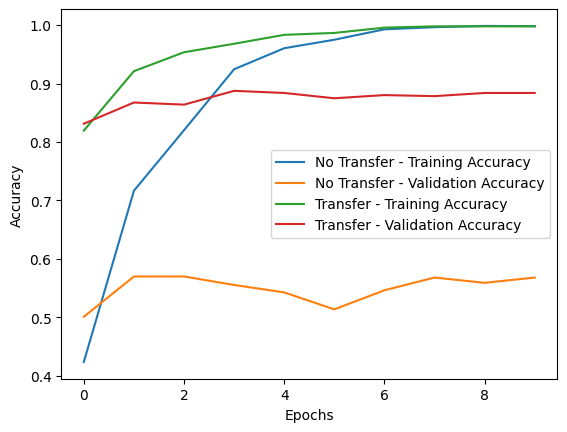

In [ ]:
import matplotlib.pyplot as plt
# Plot the accuracy curves
plt.plot(history_no_transfer.history['accuracy'], label='No Transfer - Training Accuracy')
plt.plot(history_no_transfer.history['val_accuracy'], label='No Transfer - Validation Accuracy')
plt.plot(history_transfer.history['accuracy'], label='Transfer - Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()